# Fitting reverse gradient

 In the OpticStudio knowledge base tutorial [Modelling of a Shack-Hartmann Sensor for eye aberration evaluation](https://support.zemax.com/hc/en-us/articles/4406838460819-Modelling-of-a-Shack-Hartmann-Sensor-for-eye-aberration-evaluation), a reversed eye model is created. That eye model is the reversed version of the finite eye model created in [How to model the human eye in OpticStudio](https://support.zemax.com/hc/en-us/articles/1500005575002-How-to-model-the-human-eye-in-OpticStudio). However, the reversed lens gradient is incorrectly inverted. This notebook addresses the fitting of a 'reverse' lens gradient for the crystalline lens of the eye, and shows how to correctly determine it.

### Included functionalities

This example does not show `ZOSPy` functionalities but rather shows how to obtain a reversed lens gradient for a Gradient 3 surface. 


### Warranty and liability

The examples are provided 'as is'. There is no warranty and rights cannot be derived from them, as is also stated in the general license of this repository.

## Import dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from lmfit import Parameters, minimize

First, we create a `grad3` function that is equal to the internal function of the OpticStudio Gradient3 surface.

In [2]:
def grad3(coords, n0=0, nr2=0, nr4=0, nr6=0, nz1=0, nz2=0, nz3=0) -> np.ndarray:
    """Compute a gradient3 based on radial (r) and axial (z) coordinates.

    Parameters
    ----------
    coords : numpy.ndarray
        A 2D array of shape (n, 2), where the first column represents the radial (r) component and
        the second column represents the axial (z) component. Each row corresponds to a different coordinate pair.
    n0 : float
        The constant term (default is 0).
    nr2 : float
        Coefficient for the r^2 term in the polynomial expansion. Defaults to 0.
    nr4 : float
        Coefficient for the r^4 term in the polynomial expansion. Defaults to 0.
    nr6 : float
        Coefficient for the r^6 term in the polynomial expansion. Defaults to 0.
    nz1 : float
        Coefficient for the z term in the polynomial expansion. Defaults to 0.
    nz2 : float
        Coefficient for the z^2 term in the polynomial expansion. Defaults to 0.
    nz3 : float
        Coefficient for the z^3 term in the polynomial expansion. Defaults to 0.

    Returns
    -------
    result : numpy.ndarray
        A 1D array of length n, where each element corresponds to the evaluated polynomial value for the
        corresponding (r, z) pair in the input coords.
    """
    r = coords[:, 0]
    z = coords[:, 1]
    return n0 + nr2 * r**2 + nr4 * r**4 + nr6 * r**6 + nz1 * z + nz2 * z**2 + nz3 * z**3

## Original Lens Gradient

Then, we create the gradient as it would be present in the normal, non-reversed finite eye model.

In [3]:
z_front = np.arange(0, 1.60, 0.01)
r_front = np.zeros(z_front.shape)
coords_front = np.array([r_front, z_front]).T
n_front_orig = grad3(coords_front, n0=1.368, nr2=-1.978e-003, nz1=0.049057, nz2=-0.015427)

In [4]:
z_back = np.arange(0, 2.44, 0.01)
r_back = np.zeros(z_back.shape)
coords_back = np.array([r_back, z_back]).T
n_back_orig = grad3(coords_back, n0=1.407, nr2=-1.978e-003, nz2=-6.605e-003)

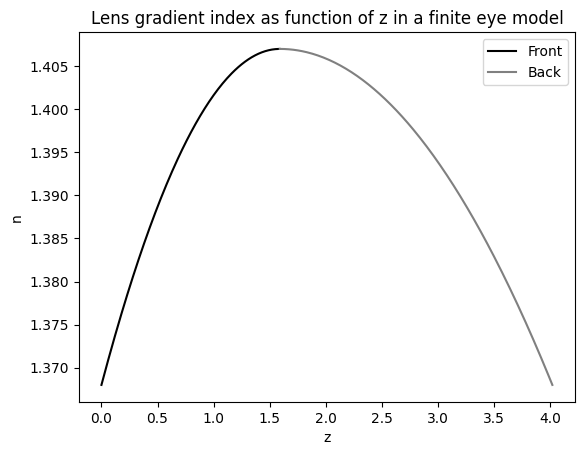

In [5]:
fig, ax = plt.subplots()

ax.plot(z_front, n_front_orig, c="k", label="Front")
ax.plot(z_back + z_front.max(), n_back_orig, c="Gray", label="Back")

ax.set_xlabel("z")
ax.set_ylabel("n")

ax.legend()
_ = ax.set_title("Lens gradient index as function of z in a finite eye model")

## Expected reversed implementation

The expected reversed gradient would be the gradient curve flipped.

In [6]:
n_back_inv_expected = n_back_orig[::-1]
n_front_inv_expected = n_front_orig[::-1]

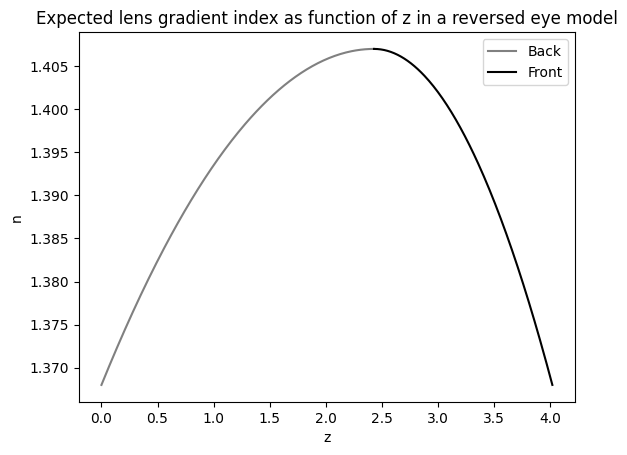

In [7]:
fig, ax = plt.subplots()

ax.plot(z_back, n_back_inv_expected, c="Gray", label="Back")
ax.plot(z_front + z_back.max(), n_front_inv_expected, c="k", label="Front")

ax.set_xlabel("z")
ax.set_ylabel("n")

ax.legend()
_ = ax.set_title("Expected lens gradient index as function of z in a reversed eye model")

## Current reversed implementation

Now, we generate the same curve based on the Gradient3 constants used in [Modelling of a Shack-Hartmann Sensor for eye aberration evaluation](https://support.zemax.com/hc/en-us/articles/4406838460819-Modelling-of-a-Shack-Hartmann-Sensor-for-eye-aberration-evaluation).

In [8]:
n_back_inv_cur = grad3(coords_back, n0=1.407, nr2=-1.978e-003, nz2=-6.605e-003)
n_front_inv_cur = grad3(coords_front, n0=1.368, nr2=-1.978e-003, nz1=-0.049057, nz2=-0.015427)

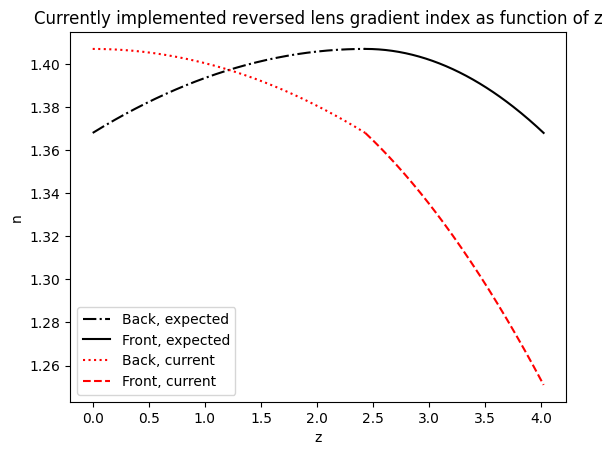

In [9]:
fig, ax = plt.subplots()

ax.plot(z_back, n_back_inv_expected, c="k", ls="-.", label="Back, expected")
ax.plot(z_front + z_back.max(), n_front_inv_expected, c="k", label="Front, expected")

ax.plot(z_back, n_back_inv_cur, c="red", ls=":", label="Back, current")
ax.plot(z_front + z_back.max(), n_front_inv_cur, c="red", ls="--", label="Front, current")

ax.set_xlabel("z")
ax.set_ylabel("n")

ax.legend()
_ = ax.set_title("Currently implemented reversed lens gradient index as function of z")

## New implementation of reverse gradient based on fit

Now, we use the `lmfit` module to fit the parameters of the reversed gradient based using the initial non-reversed gradient.

In [10]:
def residual(parameters, z, n_orig):
    """
    Compute the residual (absolute difference) between the original and new values of a function defined by `grad3`.

    This function calculates the difference between the original values (`n_orig`) and the new values computed
    by the `grad3` function using a set of polynomial coefficients provided in `parameters`. It evaluates how
    well the new values fit the original data.

    Parameters
    ----------
    parameters : lmfit.Parameters
        A dictionary-like object that holds the values of the polynomial coefficients. The keys are expected to
        be:
        - "n0": The constant term.
        - "nr2": Coefficient for the r^2 term.
        - "nr4": Coefficient for the r^4 term.
        - "nr6": Coefficient for the r^6 term.
        - "nz1": Coefficient for the z term.
        - "nz2": Coefficient for the z^2 term.
        - "nz3": Coefficient for the z^3 term.
    z : numpy.ndarray
        A 2D array of shape (n, 2) containing radial (r) and axial (z) coordinates. This is passed as input to
        the `grad3` function for evaluation.
    n_orig : numpy.ndarray
        A 1D array of original values that represents the target values to compare against the values computed by
        `grad3`.

    Returns
    -------
    residuals : numpy.ndarray
        A 1D array representing the absolute difference between `n_orig` and the values computed by `grad3`.
        This is the residual or error between the original data and the fitted model.
    """
    pars = parameters.valuesdict()
    n_new = grad3(
        z,
        n0=pars["n0"],
        nr2=pars["nr2"],
        nr4=pars["nr4"],
        nr6=pars["nr6"],
        nz1=pars["nz1"],
        nz2=pars["nz2"],
        nz3=pars["nz3"],
    )

    return abs(n_orig - n_new)

## Fitting the back surface

To fit the reversed back surface, we want to know the minimal refractive index of the original back surface, which will be the new `n0`.

In [11]:
n_back_orig.min()

np.float64(1.3679981355)

Given the symmetry of the curve, it should be sufficient to solely adjust `nz1`. Other gradient 3 implementations might require more freedom in the fitting process, and the parameters below can be adjusted accordingly.

In [12]:
params = Parameters()
params.add("n0", value=n_back_orig.min(), vary=False)
params.add("nr2", value=-1.978e-003, vary=False)
params.add("nr4", value=0.0, vary=False)
params.add("nr6", value=0.0, vary=False)
params.add("nz1", value=0, vary=True)
params.add("nz2", value=-6.605e-003, vary=False)
params.add("nz3", value=0, vary=False)

Perform the fit.

In [13]:
fitres_back = minimize(residual, params=params, args=(coords_back, n_back_inv_expected))
fitres_back.params

name,value,standard error,relative error,initial value,min,max,vary
n0,1.36799814,0.00000000,(0.00%),1.3679981355,-inf,inf,False
nr2,-0.00197800,0.00000000,(0.00%),-0.001978,-inf,inf,False
nr4,0.00000000,0.00000000,,0.0,-inf,inf,False
nr6,0.00000000,0.00000000,,0.0,-inf,inf,False
nz1,0.03210030,2.4726e-16,(0.00%),0,-inf,inf,True
nz2,-0.00660500,0.00000000,(0.00%),-0.006605,-inf,inf,False
nz3,0.00000000,0.00000000,,0,-inf,inf,False


Create the resulting gradient.

In [14]:
n_back_inv_fit = grad3(
    coords_back,
    n0=fitres_back.params["n0"].value,
    nr2=fitres_back.params["nr2"].value,
    nr4=fitres_back.params["nr4"].value,
    nr6=fitres_back.params["nr6"].value,
    nz1=fitres_back.params["nz1"].value,
    nz2=fitres_back.params["nz2"].value,
    nz3=fitres_back.params["nz3"].value,
)

## Fitting the front surface

Same process as the back surface, including the same reasoning for the fit parameters. The new `n0` should however be the maximal refractive index of the front surface.

In [15]:
n_front_orig.max()

np.float64(1.4069996313000002)

In [16]:
params = Parameters()
params.add("n0", value=n_front_orig.max(), vary=False)
params.add("nr2", value=-1.978e-003, vary=False)
params.add("nr4", value=0.0, vary=False)
params.add("nr6", value=0.0, vary=False)
params.add("nz1", value=0.049057, vary=True)
params.add("nz2", value=-0.015427, vary=False)
params.add("nz3", value=0, vary=False)

In [17]:
fitres_front = minimize(residual, params=params, args=(coords_front, n_front_inv_expected))
fitres_front.params

name,value,standard error,relative error,initial value,min,max,vary
n0,1.40699963,0.00000000,(0.00%),1.4069996313000002,-inf,inf,False
nr2,-0.00197800,0.00000000,(0.00%),-0.001978,-inf,inf,False
nr4,0.00000000,0.00000000,,0.0,-inf,inf,False
nr6,0.00000000,0.00000000,,0.0,-inf,inf,False
nz1,8.6000e-07,1.5082e-14,(0.00%),0.049057,-inf,inf,True
nz2,-0.01542700,0.00000000,(0.00%),-0.015427,-inf,inf,False
nz3,0.00000000,0.00000000,,0,-inf,inf,False


In [18]:
n_front_inv_fit = grad3(
    coords_front,
    n0=fitres_front.params["n0"].value,
    nr2=fitres_front.params["nr2"].value,
    nr4=fitres_front.params["nr4"].value,
    nr6=fitres_front.params["nr6"].value,
    nz1=fitres_front.params["nz1"].value,
    nz2=fitres_front.params["nz2"].value,
    nz3=fitres_front.params["nz3"].value,
)

## Fitting results

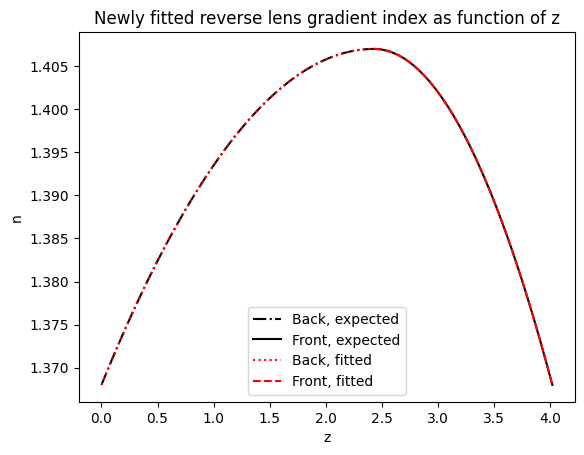

In [19]:
fig, ax = plt.subplots()

ax.plot(z_back, n_back_inv_expected, c="k", ls="-.", label="Back, expected")
ax.plot(z_front + z_back.max(), n_front_inv_expected, c="k", label="Front, expected")

ax.plot(z_back, n_back_inv_fit, c="red", ls=":", label="Back, fitted")
ax.plot(z_front + z_back.max(), n_front_inv_fit, c="red", ls="--", label="Front, fitted")

ax.set_xlabel("z")
ax.set_ylabel("n")

ax.legend()
_ = ax.set_title("Newly fitted reverse lens gradient index as function of z")

## Comparison with original implementation

Now we overlay both the original reversed lens gradient and the newly fitted reversed lens gradient over the expected reversed lens gradient, showing that the original reversed gradient matches poorly and the newly fitted one matches well.

Text(0.5, 1.0, 'New, fitted\nimplementation')

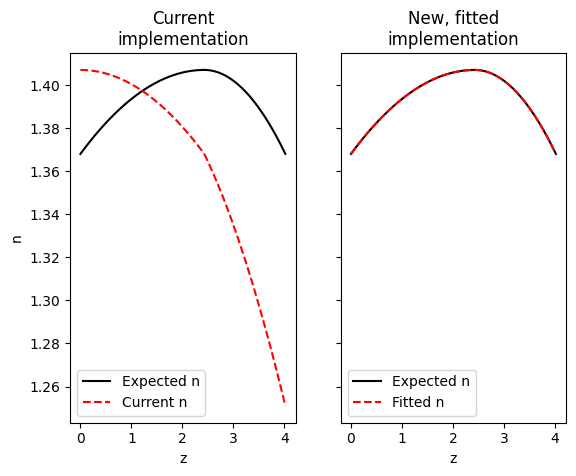

In [20]:
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)

ax[0].plot(z_back, n_back_inv_expected, c="k", label="Expected n")
ax[0].plot(z_front + z_back.max(), n_front_inv_expected, c="k")

ax[0].plot(z_back, n_back_inv_cur, c="red", ls="--", label="Current n")
ax[0].plot(z_front + z_back.max(), n_front_inv_cur, c="red", ls="--")

ax[1].plot(z_back, n_back_inv_expected, c="k", label="Expected n")
ax[1].plot(z_front + z_back.max(), n_front_inv_expected, c="k")

ax[1].plot(z_back, n_back_inv_fit, c="red", ls="--", label="Fitted n")
ax[1].plot(z_front + z_back.max(), n_front_inv_fit, c="red", ls="--")

ax[0].set_xlabel("z")
ax[1].set_xlabel("z")
ax[0].set_ylabel("n")

ax[0].legend()
ax[1].legend()

ax[0].set_title("Current\nimplementation")
ax[1].set_title("New, fitted\nimplementation")